<a href="https://colab.research.google.com/github/BirenderPanwar/EVA4_Phase1/blob/master/session15/s15_qualifier/EVA4S15_Main_Resnet_BCELogitsLoss_400k_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 15: Depth Map and Mask Prediction model

### Attempt - Custom Resnet Model (400K dataset)
- Reload the model and Resuming traning from Epoch-7 (refer Part-1 where model is trained upto 7 epochs)
- Loss: BCEWithLogitsLoss
- LR Update: LR Scheduler update Batch wise

1. created end to end model pipeline
2. created custom dataset class to load data from folder and handling data iterator
3. created CNN model that take fg_bg and bg as inputs, some conv layer chain  and generate predicted mask and depth map
4. training of model, adding necessary logs to capture intermediate output, saving epoch results, saving epoch's data inputs, ground truth and predicted output 
5. used time, memit for timing and memory profiling 
6. used memory_profiler and line_profiler package for cell and statement profiling
7. used psutil to capture memory usage in real time
8. used tensorboard package to dump realtime profiling data for analysis
9. Timing Profiling:
- how long it took to load data from disk
- captured timing details for each convolution blocks and layers for the network
- captured timing details while training model: execution time for forward, loss calculation and backpropagation
10. Memory Profiling:
- Peak memory usage while loading data, preparing of dataset and data loader
- memory usage for each epoch
11. All timing and memory usage logs are captured and passed to tensorboard for analysis.

In [0]:
# mount gdrive
from google.colab import drive
drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# check for desired GPU allocation
import torch
prop = torch.cuda.get_device_properties(0)
gpu = 'P100' #'Tesla P100-PCIE-16GB'
if prop.name.find(gpu) != -1:
   print("Welcome: ", prop.name)
else:
  print("Got GPU: ", prop.name)
  print("I need higher GPU, so restarting")
  exit()

Welcome:  Tesla P100-PCIE-16GB


In [0]:
# switch to root working directory
import os
os.chdir('/content/gdrive/My Drive/TSAI/EVA_Phase1/session14_15/s15_qualifier/')
print(os.getcwd())

/content/gdrive/My Drive/TSAI/EVA_Phase1/session14_15/s15_qualifier


# Load standard and custom python packages

In [0]:
import pkgutil

if pkgutil.find_loader("memory_profiler") is None:
  !pip install memory_profiler

if pkgutil.find_loader("line_profiler") is None:
  !pip install line_profiler

if pkgutil.find_loader("tensorboard") is None:
  !pip install tensorboard

# for Structural Similarity Index based loss calculation between two images
if pkgutil.find_loader("kornia") is None:
  !pip install kornia

  Created wheel for memory-profiler: filename=memory_profiler-0.57.0-cp36-none-any.whl size=28992 sha256=53fc5e902a264f791130fb573b1c8f2512e2c7d79ce552fb4ecca4e8b9f0bcee
  Stored in directory: /root/.cache/pip/wheels/74/20/b5/20964ef97be73d2c3a695c9cad7bccd96d1e3e737a8163861f
Successfully built memory-profiler
     |████████████████████████████████| 71kB 2.4MB/s 
     |████████████████████████████████| 163kB 3.4MB/s 


In [0]:
%load_ext line_profiler
%load_ext memory_profiler

#Load the TensorBoard extension
%load_ext tensorboard

In [0]:
# Load standard packages
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import sys
import os
from pathlib import Path
import gc
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#plt.ion()   # interactive mode

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [0]:
# load custom python packages

from utils.TimeMemoryProfile import MemoryUsage, TimeProfile
import utils.common_utils as cutils           # common utililies fxn
import utils.plot_utils as plot_utils         # utilities for ploting images, model history, misclassified images etc

from utils.depth_model_utils import DepthModelUtils # util class for depth model train, test, build fucntions
from utils.DepthMapDataset import DepthMapDatasetFolder, DepthMapDatasetFxn

In [0]:
# to autoreload all the custom files when modified
import autoreload
%load_ext autoreload
%autoreload

# Check GPU avaiability
use cuda and get device with GPU

In [0]:
# check GPU availability and use cuda to get GPU device
cuda, device = cutils.get_device()
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

CUDA Available? True
Device:  cuda:0
PyTorch 1.5.0+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


# Basis configurations

In [0]:
'''
initilize directory location for log and tensor board
'''

SOLUTION_LOG_DIR = "logs/logs_resnet_BCELogitsLoss_LR_400k_Part2"     # root directoy for all the log of this notebook
Path(f'./{SOLUTION_LOG_DIR}').mkdir(exist_ok=True)

TENSOR_BOARD_LOG_DIR = f'./{SOLUTION_LOG_DIR}/tb_logs' #root directory to log tensor board results

SAVED_MODELS_DIR = Path(f'./{SOLUTION_LOG_DIR}/saved_models') # location to save models
SAVED_MODELS_DIR.mkdir(exist_ok=True)

SAVED_RESULTS_DIR = Path(f'./{SOLUTION_LOG_DIR}/saved_results')
SAVED_RESULTS_DIR.mkdir(exist_ok=True)

PLOT_DIR = Path(f'./{SOLUTION_LOG_DIR}/doc_images')
PLOT_DIR.mkdir(exist_ok=True)

In [0]:
config_params = dict(
    seed=1,
    batch_size=32,
    num_workers=6,
    epochs=50,
    resume_training=True, # last session ran upto 6 epochs, so resume training from there
    load_model_path = Path(f'./{SOLUTION_LOG_DIR}/saved_models/model_ep6_b7000_trainloss_0.920435035.pth'), # used when resume_training is True
    dataset_size=400000, # change the size to try with small dataset: 10880, 32640, 43520, 400000
    saved_results_freq=1000, # batch iterations for saving results
    batch_lr_update=True # True: update LR batch wise, False: update LR epoch wise
)

# For reproducibility
torch.manual_seed(config_params["seed"])

if cuda:
    torch.cuda.manual_seed(config_params["seed"])

In [0]:
# for profiling
memory_usage = MemoryUsage()
time_profile = TimeProfile()
tb_writer = SummaryWriter(f'{TENSOR_BOARD_LOG_DIR}/my_board')

In [0]:
# initialize dataset locations

#zip file location
src_dataset_dir = "/content/gdrive/My Drive/TSAI/EVA_Phase1/session14_15/s15_assignment_A/dataset"
bg_zipname = f'{src_dataset_dir}/bg_images.zip'  
fg_bg_zipname = f'{src_dataset_dir}/fg_bg_images.zip'  
fg_bg_mask_zipname = f'{src_dataset_dir}/fg_bg_mask_images_c1.zip'  
fg_bg_depth_zipname = f'{src_dataset_dir}/fg_bg_depth_images.zip'  

#unzip locations: note path shall be colab internal memory location not on mounted drive.
root_dataset = '/content/eva15_dataset'
bg_dir = f'{root_dataset}/bg_images'                    # background images location
fg_bg_dir = f'{root_dataset}/fg_bg_images'              # forground-background overlay images location
fg_bg_mask_dir = f'{root_dataset}/fg_bg_mask_images_c1'    # forground-background overlay mask images location
fg_bg_depth_dir = f'{root_dataset}/fg_bg_depth_images'  # forground-background depth map images location

ds_folder_dict = {"bg": bg_dir,
                    "fgbg": fg_bg_dir,
                    "mask": fg_bg_mask_dir,
                    "depth": fg_bg_depth_dir}

### Extracting zipped dataset into colab internal memory

In [0]:
%%time

import zipfile

def extract_dataset(fn, dest):
    with open(fn, 'rb') as f:
      zf = zipfile.ZipFile(f)
      zf.extractall(dest)

if not Path(root_dataset).exists():
  Path(root_dataset).mkdir(exist_ok=True)

if not Path(bg_dir).exists():
  print("Extracting bg_images ...")
  extract_dataset(fn=bg_zipname, dest=bg_dir)

if not Path(fg_bg_dir).exists():
  print("Extracting fg_bg_images ...")
  extract_dataset(fn=fg_bg_zipname, dest=fg_bg_dir)

if not Path(fg_bg_mask_dir).exists():
  print("Extracting fg_bg_mask_images ...")
  extract_dataset(fn=fg_bg_mask_zipname, dest=fg_bg_mask_dir)

if not Path(fg_bg_depth_dir).exists():
  print("Extracting fg_bg_depth_images ...")
  extract_dataset(fn=fg_bg_depth_zipname, dest=fg_bg_depth_dir)

# display the content size
print("bg images: ", len(os.listdir(bg_dir)))
print("fg_bg images: ", len(os.listdir(fg_bg_dir)))
print("fg_bg_mask images: ", len(os.listdir(fg_bg_mask_dir)))
print("fg_bg_depth images: ", len(os.listdir(fg_bg_depth_dir)))

Extracting bg_images ...
Extracting fg_bg_images ...
Extracting fg_bg_mask_images ...
Extracting fg_bg_depth_images ...
bg images:  100
fg_bg images:  400000
fg_bg_mask images:  400000
fg_bg_depth images:  400000
CPU times: user 1min 28s, sys: 58.9 s, total: 2min 27s
Wall time: 11min 27s


In [0]:
'''
# if image folder does not exist then unzip all the dataset
if not Path(root_dataset).exists():
  print(" Directory does not exist.. unzip all dataset")
  Path(root_dataset).mkdir(exist_ok=True)
  print("unzipping bg_images ...")
  !unzip -q '{src_dataset_dir}/bg_images.zip' -d '{root_dataset}/bg_images'
  print("unzipping fg_bg_images ...")
  !unzip -q '{src_dataset_dir}/fg_bg_images.zip' -d '{root_dataset}/fg_bg_images'
  print("unzipping fg_bg_mask_images ...")
  !unzip -q '{src_dataset_dir}/fg_bg_mask_images_c1.zip' -d '{root_dataset}/fg_bg_mask_images'
  print("unzipping fg_bg_depth_images ...")
  !unzip -q '{src_dataset_dir}/fg_bg_depth_images.zip' -d '{root_dataset}/fg_bg_depth_images'
  print("unzipping completed \n")

# display the content size
print("bg images: ", len(os.listdir(bg_dir)))
print("fg_bg images: ", len(os.listdir(fg_bg_dir)))
print("fg_bg_mask images: ", len(os.listdir(fg_bg_mask_dir)))
print("fg_bg_depth images: ", len(os.listdir(fg_bg_depth_dir)))
'''

'\n# if image folder does not exist then unzip all the dataset\nif not Path(root_dataset).exists():\n  print(" Directory does not exist.. unzip all dataset")\n  Path(root_dataset).mkdir(exist_ok=True)\n  print("unzipping bg_images ...")\n  !unzip -q \'{src_dataset_dir}/bg_images.zip\' -d \'{root_dataset}/bg_images\'\n  print("unzipping fg_bg_images ...")\n  !unzip -q \'{src_dataset_dir}/fg_bg_images.zip\' -d \'{root_dataset}/fg_bg_images\'\n  print("unzipping fg_bg_mask_images ...")\n  !unzip -q \'{src_dataset_dir}/fg_bg_mask_images_c1.zip\' -d \'{root_dataset}/fg_bg_mask_images\'\n  print("unzipping fg_bg_depth_images ...")\n  !unzip -q \'{src_dataset_dir}/fg_bg_depth_images.zip\' -d \'{root_dataset}/fg_bg_depth_images\'\n  print("unzipping completed \n")\n\n# display the content size\nprint("bg images: ", len(os.listdir(bg_dir)))\nprint("fg_bg images: ", len(os.listdir(fg_bg_dir)))\nprint("fg_bg_mask images: ", len(os.listdir(fg_bg_mask_dir)))\nprint("fg_bg_depth images: ", len(os.li

In [0]:
# more about dataset
import pandas as pd
df_ds = pd.read_csv(f'{src_dataset_dir}/dataset_summary.csv')
df_ds

,Unnamed: 0,Kinds,Total Images,Total Size (MB),Image Dimension,Channels,Means,Stds
0,0,bg,100,1.888,"(192, 192)",3,[142.3604 129.986 115.9921],[65.6258 64.9718 65.5989]
1,1,fg,100,0.456,size of an object in image,3,NaN,NaN
2,2,fg_mask,100,0.289,same as fg image,1,NaN,NaN
3,3,fg_bg,400000,7941.210,"(192, 192)",3,[142.8615 130.0039 117.2206],[66.4145 65.5184 66.0169]
4,4,fg_bg_mask,400000,846.108,"(192, 192)",1,[23.2702],[72.9364]
5,5,fg_bg_depth,400000,3237.788,"(240, 240)",1,[147.4633],[72.0034]


In [0]:
# dataset means and stds
bg_means, bg_stds = np.round(np.array([142.3604, 129.986, 115.9921])/255., 3) , np.round(np.array([65.6258, 64.9718, 65.5989])/255., 3)
fg_bg_means, fg_bg_stds =  np.round(np.array([142.8615, 130.0039, 117.2206])/255., 3) ,	 np.round(np.array([66.4145, 65.5184, 66.0169])/255., 3)
mask_means, mask_stds =  np.round(np.array([23.2702])/255., 3) ,  np.round(np.array([72.9364])/255., 3)
depth_means, depth_stds =  np.round(np.array([147.4633])/255., 3) ,  np.round(np.array([72.0034])/255., 3)

ds_means_stds = {
    "bg_means": bg_means,
    "bg_stds": bg_stds,
    "fg_bg_means": fg_bg_means,
    "fg_bg_stds": fg_bg_stds,
    "mask_means": mask_means,
    "mask_stds": mask_stds,
    "depth_means": depth_means,
    "depth_stds": depth_stds,
}

ds_means_stds

{'bg_means': array([0.558, 0.51 , 0.455]),
 'bg_stds': array([0.257, 0.255, 0.257]),
 'depth_means': array([0.578]),
 'depth_stds': array([0.282]),
 'fg_bg_means': array([0.56, 0.51, 0.46]),
 'fg_bg_stds': array([0.26 , 0.257, 0.259]),
 'mask_means': array([0.091]),
 'mask_stds': array([0.286])}

In [0]:
#bg_means, bg_stds = np.round(np.array([142.3604, 129.986, 115.9921]), 3) , np.round(np.array([65.6258, 64.9718, 65.5989]), 3)
#fg_bg_means, fg_bg_stds =  np.round(np.array([142.8615, 130.0039, 117.2206]), 3) ,	 np.round(np.array([66.4145, 65.5184, 66.0169]), 3)
#mask_means, mask_stds =  np.round(np.array([23.2702]), 3) ,  np.round(np.array([72.9364]), 3)
#depth_means, depth_stds =  np.round(np.array([147.4633]), 3) ,  np.round(np.array([72.0034]), 3)

In [0]:
from torchvision.transforms import transforms

# keep all image size same for simplicity
img_size = (192,192)

# train transforms
train_bg_transform = transforms.Compose([
                              #transforms.Resize(size=(img_size)),
                              transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.15),           
                              transforms.ToTensor(),
                              transforms.Normalize(bg_means, bg_stds),
                              transforms.RandomErasing(scale=(0.02, 0.10), ratio=(0.8, 1.2)) # cut-out                           
                              ])

train_fgbg_transform = transforms.Compose([
                              #transforms.Resize(size=img_size),
                              transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.15),
                              transforms.ToTensor(),
                              transforms.Normalize(fg_bg_means, fg_bg_stds),
                              transforms.RandomErasing(scale=(0.02, 0.10), ratio=(0.8, 1.2)) # cut-out
                              ])

# test transforms
test_bg_transform = transforms.Compose([
                              #transforms.Resize(size=img_size),
                              transforms.ToTensor(),
                              transforms.Normalize(bg_means, bg_stds)
                              ])

test_fgbg_transform = transforms.Compose([
                              #transforms.Resize(size=img_size),
                              transforms.ToTensor(),
                              transforms.Normalize(fg_bg_means, fg_bg_stds)
                              ])

# transform for mask and depth (for both train and test dataset)
gt_transform=transforms.Compose([
                              transforms.Resize(size=img_size),
                              transforms.ToTensor()
                              ])

In [0]:
train_filename = "train_filelist_400k.txt"
test_filename = "test_filelist_400k.txt"

'''
1. reuse the images file list names if dataset was already created before. 
2. this is to ensure that same train and test samples are used every time notebook is restarted. 
3. This helps to facilitiate save model and train further using the same set of data samples 
4. To help experiment and compare different models and loss fxn, we need to ensure same data samples are used every time so that results are comparables
5. To help avoiding data leak every time notenook is restarted
'''
if Path(train_filename).exists():
  print(f"Reading train image names from {train_filename}")
  train_files = DepthMapDatasetFxn().read_img_filenames(train_filename)
  print(f"Reading test image names from {test_filename}")
  test_files = DepthMapDatasetFxn().read_img_filenames(test_filename)
else:
  all_files = DepthMapDatasetFxn().get_random_filelist(os.listdir(fg_bg_dir))
  train_files, test_files = DepthMapDatasetFxn().train_test_split(all_files, test_size=0.3) # train:test: 70:30 with shuffle dataset
  print(f"Saving train image names to {train_filename}")
  DepthMapDatasetFxn().save_img_filenames(train_files, train_filename)
  print(f"Saving Test image names to {test_filename}")
  DepthMapDatasetFxn().save_img_filenames(test_files, test_filename)


Reading train image names from train_filelist_400k.txt
Reading test image names from test_filelist_400k.txt


In [0]:
'''
1. train_files contain shuffle filename of 70% of entire dataset
2. test_files contain shuffle filename of 30% of entire dataset
3. in case to expereiment with small dataset..pick that from train and test files
'''
if config_params['dataset_size'] != 400000:
  train_size = int(np.round(config_params['dataset_size']*0.7))
  train_files = train_files[:train_size]
  test_files = test_files[train_size:config_params['dataset_size']]

In [0]:
train_files[:5]

['fg021_bg012_08.jpg',
 'fg065flip_bg028_06.jpg',
 'fg094flip_bg038_03.jpg',
 'fg077_bg006_14.jpg',
 'fg100_bg028_13.jpg']

['fg021_bg012_08.jpg',
 'fg065flip_bg028_06.jpg',
 'fg094flip_bg038_03.jpg',
 'fg077_bg006_14.jpg',
 'fg100_bg028_13.jpg']

In [0]:
%%time
%%memit
train_dataset = DepthMapDatasetFolder(ds_folder_dict, im_files=train_files, 
                                bg_transform = train_bg_transform, 
                                fgbg_transform = train_fgbg_transform, 
                                mask_transform = gt_transform,
                                depth_transform = gt_transform)

test_dataset = DepthMapDatasetFolder(ds_folder_dict, im_files=test_files, 
                               bg_transform = test_bg_transform, 
                               fgbg_transform = test_fgbg_transform, 
                               mask_transform = gt_transform,
                               depth_transform = gt_transform)

peak memory: 535.12 MiB, increment: 0.04 MiB
CPU times: user 107 ms, sys: 30.9 ms, total: 138 ms
Wall time: 274 ms


In [0]:
# Note: dataset load all 100 bg images and can internally prepare all bg from the 100 images. its basically reusing the existing images 
print(f'train count: {len(train_dataset)}')
print(f'test count: {len(test_dataset)}')

train count: 280000
test count: 120000


In [0]:
# dataset dimensions
[(k, v.shape) for k, v in train_dataset[0].items()]

[('bg', torch.Size([3, 192, 192])),
 ('fgbg', torch.Size([3, 192, 192])),
 ('mask', torch.Size([1, 192, 192])),
 ('depth', torch.Size([1, 192, 192]))]

In [0]:
from torch.utils.data import DataLoader

dataloader_args = dict(shuffle=True, batch_size=config_params["batch_size"], num_workers=config_params["num_workers"], pin_memory=True) if cuda else dict(shuffle=True, batch_size=8)

train_loader = DataLoader(train_dataset, **dataloader_args)
test_loader = DataLoader(test_dataset, **dataloader_args)


In [0]:
samples = next(iter(train_loader))
[(k, v.shape) for k, v in samples.items()]

[('bg', torch.Size([32, 3, 192, 192])),
 ('fgbg', torch.Size([32, 3, 192, 192])),
 ('mask', torch.Size([32, 1, 192, 192])),
 ('depth', torch.Size([32, 1, 192, 192]))]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


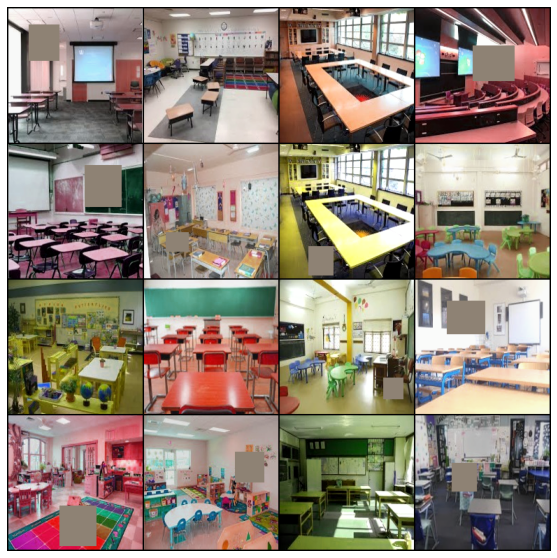

peak memory: 3430.85 MiB, increment: 120.49 MiB
CPU times: user 615 ms, sys: 122 ms, total: 737 ms
Wall time: 899 ms


<Figure size 432x288 with 0 Axes>

In [0]:
%%time
%%memit 
plot_utils.visualize_data_norm(samples["bg"], bg_means, bg_stds, figsize=(10,10), filename=PLOT_DIR/f'bg_img2.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


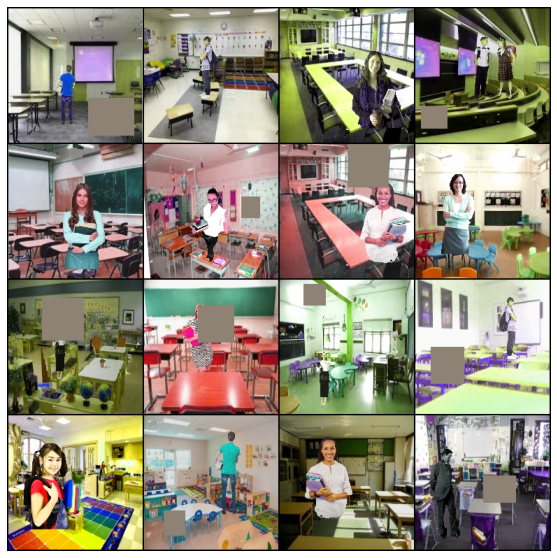

<Figure size 432x288 with 0 Axes>

In [0]:
plot_utils.visualize_data_norm(samples["fgbg"], fg_bg_means, fg_bg_stds, figsize=(10,10), filename=PLOT_DIR/f'fgbg_img2.jpg')

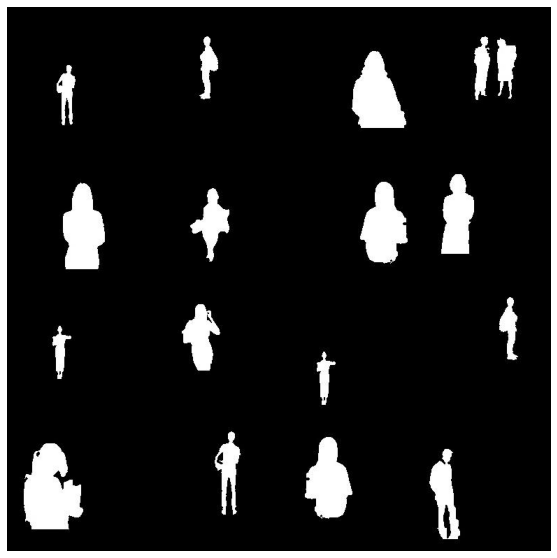

<Figure size 432x288 with 0 Axes>

In [0]:
plot_utils.visualize_data(samples["mask"], figsize=(10,10), filename=PLOT_DIR/f'mask_img2.jpg')

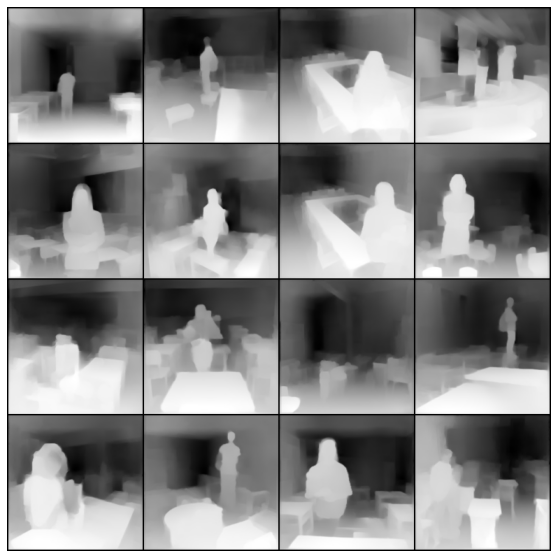

<Figure size 432x288 with 0 Axes>

In [0]:
plot_utils.visualize_data(samples["depth"], figsize=(10,10), filename=PLOT_DIR/f'depth_img2.jpg')

In [0]:
# Write to tensor board
grid_bg = torchvision.utils.make_grid(samples["bg"], nrow=4)
grid_fgbg = torchvision.utils.make_grid(samples["fgbg"], nrow=4)
grid_mask = torchvision.utils.make_grid(samples["mask"], nrow=4)
grid_depth = torchvision.utils.make_grid(samples["depth"], nrow=4)

tb_writer.add_image("sample_bg", grid_bg, 0)
tb_writer.add_image("sample_fgbg", grid_fgbg, 0)
tb_writer.add_image("sample_mask", grid_mask, 0)
tb_writer.add_image("sample_depth", grid_depth, 0)

In [0]:
from  models.depthmap.DMNet_Resnet import ResnetDepthNet
from torchsummary import summary

# Create model
model_name = "ResnetDepthMap"
model = ResnetDepthNet()
model = model.to(device)

summary(model, input_size=(6, 192, 192)) #input is bg + fgbg

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 192, 192]             864
       BatchNorm2d-2         [-1, 16, 192, 192]              32
            Conv2d-3         [-1, 32, 192, 192]           4,608
       BatchNorm2d-4         [-1, 32, 192, 192]              64
            Conv2d-5         [-1, 32, 192, 192]           9,216
       BatchNorm2d-6         [-1, 32, 192, 192]              64
            Conv2d-7         [-1, 32, 192, 192]             512
       BatchNorm2d-8         [-1, 32, 192, 192]              64
          ResBlock-9         [-1, 32, 192, 192]               0
           Conv2d-10         [-1, 48, 192, 192]          13,824
      BatchNorm2d-11         [-1, 48, 192, 192]              96
           Conv2d-12         [-1, 48, 192, 192]          20,736
      BatchNorm2d-13         [-1, 48, 192, 192]              96
           Conv2d-14         [-1, 48, 1

In [0]:
print(model)

ResnetDepthNet(
  (conv1): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (layer2): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(48, eps=1e-05, 

In [0]:
max_lr = 0.01   # maximum LR as per LRFinder result
min_lr = 1e-4   # minimum LR as per LRFinder result
print("MAX LR: ", max_lr)
print("MIN LR: ", min_lr)

MAX LR:  0.01
MIN LR:  0.0001


In [0]:
# common utility fucntion

'''
Loss class to combine loss of mask and depth
Analysis: 
1. comparitively loss for Depth is higher than that of Mask and it is obvious as depth have much more objects and its gradient to captures.
2. total loss is calculated as sum of square root losses. square root have a property that for decimal values(betw 0 to 1), lower values yield higher result compare to higher values
doing so the loss ratio get reduce. even though total loss increases but loss ratio is reduces
'''
class CustomLoss_SqrtSum():
  def __init__(self, criterion):
      self.criterion = criterion

  def __call__(self, output_m, target_m, output_d, target_d):
      loss_m = self.criterion(output_m, target_m)
      loss_d = self.criterion(output_d, target_d)
      loss = torch.sqrt(loss_m) + torch.sqrt(loss_d)
      return loss, loss_m, loss_d

class CustomLoss_WeightedSum():
  def __init__(self, criterion, m_wt=1, d_wt=1):
      self.criterion = criterion
      self.m_wt = m_wt
      self.d_wt = d_wt

  def __call__(self, output_m, target_m, output_d, target_d):
      loss_m = self.criterion(output_m, target_m)
      loss_d = self.criterion(output_d, target_d)
      loss = self.m_wt*loss_m + self.d_wt*loss_d
      return loss, loss_m, loss_d

def transfer_optimizer(optzr, device):
    # now individually transfer the optimizer parts...
    for state in optzr.state.values():
      for k, v in state.items():
        if isinstance(v, torch.Tensor):
          state[k] = v.to(device)

def load_checkpoint(model, optimizer, device, filename):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        losslogger = checkpoint['losslogger']

        print("=> loading optimizer states..")
        transfer_optimizer(optimizer, device)
        
        print("=> loaded checkpoint '{}' (epoch {})".format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch, losslogger



In [0]:
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau
import kornia

start_epoch = 1
EPOCHS = config_params["epochs"]
L2_val = 1e-4 

# stepsize for LR cycle policy
batch_lr_update = config_params["batch_lr_update"] # whether to update LR batch wise or epoch wise
if batch_lr_update:
  step_size = 2000 #keeping 4000 batch as one LR cycle 
else:
  step_size = 8 # num of epoch, if LR is update epoch wise

'''
refered loss fxn: 
1. https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7
2. For SSIM: https://torchgeometry.readthedocs.io/en/latest/_modules/kornia/losses/ssim.html
'''

#criterion = CustomLoss_SqrtSum(nn.SmoothL1Loss()) # Smooth L1 Loss
#criterion = CustomLoss_WeightedSum(nn.MSELoss()) # L2 Loss
criterion = CustomLoss_SqrtSum(nn.BCEWithLogitsLoss()) #total is sum of sqrt of mask and sqrt of depth loss
#criterion = CustomLoss_WeightedSum(kornia.losses.SSIM(3, reduction='mean')) #total is sum of mask and depth loss

optimizer = optim.SGD(model.parameters(), lr=min_lr, momentum=0.9, nesterov=True, weight_decay=L2_val)

# CyclicLR-Triangular policy
lr_scheduler = CyclicLR(optimizer, base_lr=min_lr, max_lr=max_lr, step_size_up=step_size, step_size_down=step_size, mode='triangular2', last_epoch=-1)
#lr_scheduler = MultiStepLR(optimizer, milestones=[8,16,24], gamma=0.3)
#lr_scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

# reduce LR when model get stuck in plateau region
reduceLr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.001)

In [0]:
# free all unsued memory and then start training
print(gc.collect())
print(memory_usage.show())

10438
{'delta': 2845.6755, 'percent_used': 13.1, 'used': 3605.9218}


In [0]:
from utils.depth_model_utils import DepthModelUtils # util class for depth model train, test, build fucntions
dmodel_utils = DepthModelUtils(ds_means_stds=ds_means_stds, 
                               saved_model_dir=SAVED_MODELS_DIR, 
                               saved_results_dir=SAVED_RESULTS_DIR, 
                               tb_log_dir=TENSOR_BOARD_LOG_DIR,
                               saved_results_freq = config_params["saved_results_freq"], # batch freq
                               tqdm_status=True)

### Fresh Training or Resuming Training

In [0]:
# if resuming the traning then load the model, update optimizer states and loss state
if config_params["resume_training"] == True:
  print("This is resuming the training session...")
  model, optimizer, start_epoch, criterion = load_checkpoint(model, optimizer, device, config_params["load_model_path"])
else:
  print("This is fresh attempt training ...")

This is resuming the training session...
=> loading checkpoint 'logs/logs_resnet_BCELogitsLoss_LR_400k_Part2/saved_models/model_ep6_b7000_trainloss_0.920435035.pth'
=> loading optimizer states..
=> loaded checkpoint 'logs/logs_resnet_BCELogitsLoss_LR_400k_Part2/saved_models/model_ep6_b7000_trainloss_0.920435035.pth' (epoch 7)


### Traning the model

In [0]:
m_history = dmodel_utils.build_model(model, 
                            device, 
                            trainloader=train_loader, 
                            testloader=test_loader, 
                            start_epoch=start_epoch,
                            epochs=EPOCHS,
                            criterion=criterion, 
                            optimizer=optimizer,
                            lr_scheduler=lr_scheduler,
                            batch_lr_update=batch_lr_update,
                            reduceLr_scheduler=reduceLr_scheduler,
                            L1_loss_enable=False)

In [0]:
tb_writer.close()

In [0]:
#print(TENSOR_BOARD_LOG_DIR)

### Visualize Tensorboard

In [0]:
import pkgutil
if pkgutil.find_loader("tensorboard") is None:
  !pip install tensorboard
  
#Load the TensorBoard extension
%load_ext tensorboard

In [0]:
# switch to root working directory
import os
os.chdir('/content/gdrive/My Drive/TSAI/EVA_Phase1/session14_15/s15_qualifier/')
print(os.getcwd())

/content/gdrive/My Drive/TSAI/EVA_Phase1/session14_15/s15_qualifier


In [0]:
%tensorboard --logdir ./logs/logs_resnet_BCELogitsLoss_LR_400k_Part2/tb_logs

In [0]:
#MAX RAM avaiable for assigned GPU while running notebook was 12.72 GB